In [163]:
import pandas as pd
import numpy as np
import wfdb
import ast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]  # Bigger images
sns.set()

from chart_studio import plotly
from plotly import tools
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from scipy.signal import savgol_filter
import neurokit2 as nk
import multiprocessing

import warnings

from sklearn import metrics


DB_ROOT = 'data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

### Предварительный анализ данных

Делим scp_codes на отдельные колонки. Проверяем сбалансированность классов.

In [210]:
SCP_LABELS = {
    'SR': 'sinus rhythm',
    'SARRH': 'sinus arrhythmia',
    'SBRAD': 'bradycardia',
    'STACH': 'sinus tachycardia',
    'AFIB': 'artrial fibrillation',
}
SCP_LABELS_ARR = ['SR', 'SARRH', 'SBRAD', 'STACH', 'AFIB']

In [211]:
Y = pd.read_csv(f'{DB_ROOT}/ptbxl_database.csv')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Split scp labels into separate columns
for scp_label in SCP_LABELS_ARR:
    Y[scp_label] = Y.scp_codes.apply(lambda x: int(scp_label in x))

# If one of the illnesses or normal
Y['labels_cnt'] = Y[SCP_LABELS_ARR].sum(axis=1)
Y['has_label'] = Y.labels_cnt > 0

Y.head(2)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,SR,SARRH,SBRAD,STACH,AFIB,labels_cnt,has_label
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0,1,True
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0,0,1,0,0,1,True


In [212]:
def count_nonzero(x):
    return np.sum(x > 0)

Y[['strat_fold', 'has_label', 'ecg_id'] + SCP_LABELS_ARR].groupby(['strat_fold', 'has_label']).agg(count_nonzero).reset_index()

,strat_fold,has_label,ecg_id,SR,SARRH,SBRAD,STACH,AFIB
0,1,False,126,0,0,0,0,0
1,1,True,2051,1678,77,63,82,151
2,2,False,131,0,0,0,0,0
3,2,True,2053,1678,77,64,83,151
4,3,False,144,0,0,0,0,0
5,3,True,2050,1678,77,63,82,151
6,4,False,121,0,0,0,0,0
7,4,True,2054,1679,77,64,83,151
8,5,False,121,0,0,0,0,0
9,5,True,2055,1679,78,64,83,152


Видим, что лейблов SR (синусовый ритм) слишком много. Оставим в каждом фолде по 100 псевдо-случайных ЭКГ со статусом SR.

In [213]:
def get_random_n(obj, n, replace=False, seed=123):
    np.random.seed(seed)
    return obj.loc[np.random.choice(obj.index, n, replace), :]
    
SR_ecgids = Y[Y.SR == 1].groupby('strat_fold', as_index=False).apply(lambda r: get_random_n(r, 100))['ecg_id'].values

In [214]:
Y = Y[(Y.SR == 0) | (Y.ecg_id.isin(SR_ecgids))]
Y[['strat_fold', 'has_label', 'ecg_id'] + SCP_LABELS_ARR].groupby(['strat_fold', 'has_label']).agg(count_nonzero).reset_index()

,strat_fold,has_label,ecg_id,SR,SARRH,SBRAD,STACH,AFIB
0,1,False,126,0,0,0,0,0
1,1,True,473,100,77,63,82,151
2,2,False,131,0,0,0,0,0
3,2,True,475,100,77,64,83,151
4,3,False,144,0,0,0,0,0
5,3,True,472,100,77,63,82,151
6,4,False,121,0,0,0,0,0
7,4,True,475,100,77,64,83,151
8,5,False,121,0,0,0,0,0
9,5,True,476,100,78,64,83,152


Cчитаем, как часто встречаются несколько labels для одной ЭКГ.<br>
P.S. Для данной задачи всего 3 случая.

In [215]:
print(f"ECG-examples with more than 1 label: {Y[Y.labels_cnt > 1].shape[0]}")
Y[Y.labels_cnt > 1][['report', 'scp_codes']]

ECG-examples with more than 1 label: 3


,report,scp_codes
283,"sinus bradycardia with sinus arrhythmia. the cause of the bradycardia is not evident. voltages are high in chest leads suggesting lvh. st segments are depressed in i, ii, avl, v4,5,6. this may be ...","{'LVH': 100.0, 'ISC_': 100.0, 'DIG': 100.0, 'VCLVH': 0.0, 'STD_': 0.0, 'SBRAD': 0.0, 'SARRH': 0.0}"
10362,"sinus bradycardia with sinus arrhythmia. the bradycardia may be physiological. st segments are elevated in i, ii, avf, v2-6, this is probably a normal variant. high v lead voltages are probably...","{'NORM': 100.0, 'SBRAD': 0.0, 'SARRH': 0.0}"
12282,sinus bradycardia with sinus arrhythmia. otherwise normal ecg. the cause of the bradycardia is not evident.,"{'NORM': 80.0, 'SBRAD': 0.0, 'SARRH': 0.0}"


### Готовим train/validation/test датасеты и вспомогательные функции

In [218]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f"{path}/{f}") for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f"{path}/{f}") for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

X = load_raw_data(Y, 100, DB_ROOT)

# Clean ECG signal
X = np.apply_along_axis(nk.ecg_clean, 1, X, 100)

# From the dataset recommendations
val_fold = 9
test_fold = 10

# Train dataset
X_train = X[np.where((Y.strat_fold != val_fold) & (Y.strat_fold != test_fold))]
Y_train = Y[(Y.strat_fold != val_fold) & (Y.strat_fold != test_fold)]

# Validation dataset
X_val = X[np.where(Y.strat_fold == val_fold)]
Y_val = Y[Y.strat_fold == val_fold]

# Test dataset
X_test = X[np.where(Y.strat_fold == test_fold)]
Y_test = Y[Y.strat_fold == test_fold]


In [275]:
# Iterates through the folds
def iter_batch(X, Y, X_meta=None):
    for fold in sorted(Y.strat_fold.unique()):
        X_batch_train = X[np.where(Y.strat_fold == fold)]
        Y_batch_train = Y[Y.strat_fold == fold]
        if X_meta is None:
            yield X_batch_train, Y_batch_train, None
        else:
            X_meta_batch_train = X_meta[np.where(Y.strat_fold == fold)]
            yield X_batch_train, Y_batch_train, X_meta_batch_train


def multiclass_accuracy(pred, y):
    pred = np.rint(pred)
    return sum((y == pred).all(axis=1)) / y.shape[0]


def print_metrics(y_true, y_pred_weights, labels):
    labels_accuracy = []
    labels_roc_auc = []
    labels_f1 = []
    labels_TPR = [] # Sensitivity, Recall, TPR = TP/(TP+FN)
    labels_TNR = [] # Specificity, TNR = TN/(TN+FP)
    
    y_pred = np.rint(y_pred_weights)
    for i, label in enumerate(labels):
        m1 = metrics.accuracy_score(y_pred[:, i], y_true[:, i])
        labels_accuracy.append(m1)
        m2 = metrics.roc_auc_score(y_true[:, i], y_pred_weights[:, i])
        labels_roc_auc.append(m2)
        m3 = metrics.f1_score(y_true[:, i], y_pred[:, i])
        labels_f1.append(m3)
        CM = metrics.confusion_matrix(y_true[:, i], y_pred[:, i])
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        m4 = TP/(TP+FN)
        m5 = TN/(TN+FP)
        labels_TPR.append(m4)
        labels_TNR.append(m5)
        print(f"{label}, acc: {m1}, ROC AUC: {m2}, f1: {m3}, TPR: {m4}, TNR: {m5}")

    mc1 = multiclass_accuracy(y_pred, y_true)
    mc2 = np.mean(labels_roc_auc)
    mc3 = np.mean(labels_f1)
    mc4 = np.mean(labels_TPR)
    mc5 = np.mean(labels_TNR)
    print(f"Total, acc: {mc1}, mean ROC AUC: {mc2}, mean f1: {mc3}, mean TPR: {mc4}, mean TNR: {mc5}")


def train_model(model, X_train, X_val, Y_train, Y_val, model_path, y_labels,
                X_train_meta=None, X_val_meta=None, epochs=100, print_loss=True):
    X_val_T = torch.Tensor(np.transpose(X_val, [0, 2, 1]))
    y_val = Y_val[y_labels].values
    
    X_meta_val_T = None
    if X_val_meta is not None:
        X_meta_val_T = torch.Tensor(X_val_meta)
    
    train_avg_accuracy = []
    val_accuracy = []
    
    best_val_accuracy = 0.

    for epoch in range(0, epochs):
        batches_accuracy = []
        for (X_batch_train, Y_batch_train, X_meta_batch_train) in iter_batch(X_train, Y_train, X_train_meta):
            X_batch_train_T = torch.Tensor(np.transpose(X_batch_train, [0, 2, 1]))
            y_batch_train = Y_batch_train[y_labels].values
            y_batch_train_T = torch.Tensor(y_batch_train)
            
            X_meta_batch_train_T = None
            if X_meta_batch_train is not None:
                X_meta_batch_train_T = torch.Tensor(X_meta_batch_train)
                model.fit((X_batch_train_T, X_meta_batch_train_T), y_batch_train_T, print_loss=print_loss)
                batch_train_prediction = model.predict((X_batch_train_T, X_meta_batch_train_T)).detach().numpy()
            else:
                model.fit(X_batch_train_T, y_batch_train_T, print_loss=print_loss)
                batch_train_prediction = model.predict(X_batch_train_T).detach().numpy()
            batches_accuracy.append((multiclass_accuracy(batch_train_prediction, y_batch_train)))

        train_avg_accuracy.append(np.mean(batches_accuracy))
        if X_meta_val_T is not None:
            val_prediction = model.predict((X_val_T, X_meta_val_T)).detach().numpy()
        else:
            val_prediction = model.predict(X_val_T).detach().numpy()
        val_accuracy.append(multiclass_accuracy(val_prediction, y_val))
        if val_accuracy[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracy[-1]
            model.save(model_path)
        
        print(f'EPOCH {epoch}')
        print(f'Avg train accuracy: {train_avg_accuracy[-1]}')
        print(f'Validation accuracy: {val_accuracy[-1]}')
        

### Обучаем простую CNN-модель

In [253]:
# converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Print(nn.Module):
    def forward(self, x):
        print(f'{x.size()}')
        return x

class ECGNet(nn.Module):
    def __init__(self, print_layer=False):
        super(ECGNet, self).__init__()

        self.final = nn.Sequential(
            # input: [n, 12, 1000]
            nn.Conv1d(in_channels=12, out_channels=24, kernel_size=17, stride=2), # output: [n, 24, 492]
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(in_channels=24, out_channels=48, kernel_size=10, stride=2),  # output: [n, 48, 242]
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(in_channels=48, out_channels=96, kernel_size=10, stride=2),  # output: [n, 96, 117]
            nn.BatchNorm1d(96),
            nn.MaxPool1d(3, stride=2), # output: [n, 96, 58]
            nn.ReLU(),
            nn.Dropout(0.5),
            Flatten(),
            nn.Linear(5568, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.Linear(25, 5),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        output = self.final(X)
        return output

class ECGClassifier:
    def __init__(self, model, print_layer=False, lr=0.001):
        self.model = model
        self.criterion = torch.nn.BCELoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)

    def fit(self, X, y, print_loss=False):
        self.model.train()
        self.opt.zero_grad()      
        prediction = self.model(X)
        loss = self.criterion(prediction, y)
        if print_loss:
            print(loss)
        loss.backward()
        self.opt.step()
                              
    def predict(self, X):
        self.model.eval()
        return self.model(X)
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()
        
# class ECGClassifier:
#     def __init__(self, with_meta=False, print_layer=False, lr=0.001):

#     def fit(self, X, y, X_meta=None):
#         self.model.train()
#         self.opt.zero_grad()      
#         if X_meta is not None:
#             prediction = self.model((X, X_meta))
#         else:
#             prediction = self.model(X)
#         loss = self.criterion(prediction, y)
#         print(loss)
#         loss.backward()
#         self.opt.step()
                              
#     def predict(self, X, X_meta=None):
#         self.model.eval()
#         if X_meta is not None:
#             return self.model((X, X_meta))
#         return self.model(X)

In [264]:
simple_model = ECGClassifier(ECGNet())
simple_model_path = './models/simple_ecg'
train_model(simple_model, X_train, X_val, Y_train, Y_val,
            simple_model_path, SCP_LABELS_ARR, epochs=75)

tensor(0.6640, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5092, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4613, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4440, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4313, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 0
Avg train accuracy: 0.2025794087636726
Validation accuracy: 0.22764227642276422
tensor(0.4267, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4248, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4196, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4240, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4171, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4236, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4207, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 1
Avg train accuracy: 0.21174691566461312
Validation accur

KeyboardInterrupt: 

Считаем необходимые метрики на тестовом датасете

In [258]:
simple_model = ECGClassifier(ECGNet())
simple_model.load(simple_model_path)
X_test_T = torch.Tensor(np.transpose(X_test, [0, 2, 1]))
y_true = Y_test[SCP_LABELS_ARR].values
y_pred_weights = simple_model.predict(X_test_T).detach().numpy()
print_metrics(y_true, y_pred_weights, [SCP_LABELS[scp] for scp in SCP_LABELS_ARR])

sinus rhythm, acc: 0.84, ROC AUC: 0.4379142857142858, f1: 0.0, TPR: 0.0, TNR: 1.0
sinus arrhythmia, acc: 0.8784, ROC AUC: 0.4994487585082926, f1: 0.0, TPR: 0.0, TNR: 1.0
bradycardia, acc: 0.8976, ROC AUC: 0.5864249108734403, f1: 0.0, TPR: 0.0, TNR: 1.0
sinus tachycardia, acc: 0.8688, ROC AUC: 0.45881058258096397, f1: 0.0, TPR: 0.0, TNR: 1.0
artrial fibrillation, acc: 0.7568, ROC AUC: 0.5054175475687104, f1: 0.0, TPR: 0.0, TNR: 1.0
Total, acc: 0.6112, mean ROC AUC: 0.4976032170491386, mean f1: 0.0, mean TPR: 0.0, mean TNR: 1.0


/Users/nediolus/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/Users/nediolus/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/Users/nediolus/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/Users/nediolus/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/Users/nediolus/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



### Выделяем мета-признаки

In [246]:
def get_intervals(x, y=None):
    if y is not None:
        min_len = min(len(x), len(y))
        return y[:min_len] - x[:min_len]
    elif len(x) > 1:
        return x[1:] - x[:-1]
    return np.array([])

def get_distr_features(x, sr=100):
    if not len(x):
        return 0, 0, 0, 0
    norm_coef = sr if sr else 1.0
    fmax = np.max(x) / norm_coef
    fmin = np.max(x) / norm_coef
    fmean = np.mean(x) / norm_coef
    fstd = np.std(x) / norm_coef
    return fmax, fmin, fmean, fstd

def get_ecg_meta(ecg, sr=100):
    try:
        df, info = nk.ecg_process(ecg, sampling_rate=sr)
    except Exception as ex:
        return np.array([0.7, 1., 1., 1.])
    
    # for tachycardia and bradycardia diagnosis
    if df.ECG_Rate.values[0] is not None:
        mean_rate = df.ECG_Rate.mean()
    else:
        mean_rate = 0
    
    # peaks features
#     P_max, P_min, P_mean, P_std = get_distr_features(df[df.ECG_P_Peaks == 1].ECG_Clean.values)
#     Q_max, Q_min, Q_mean, Q_std = get_distr_features(df[df.ECG_Q_Peaks == 1].ECG_Clean.values)
#     R_max, R_min, R_mean, R_std = get_distr_features(df[df.ECG_R_Peaks == 1].ECG_Clean.values)
#     S_max, S_min, S_mean, S_std = get_distr_features(df[df.ECG_S_Peaks == 1].ECG_Clean.values)
#     T_max, T_min, T_mean, T_std = get_distr_features(df[df.ECG_T_Peaks == 1].ECG_Clean.values)

    # intervals features
    P_peaks = df[df.ECG_P_Peaks == 1].index
    Q_peaks = df[df.ECG_Q_Peaks == 1].index
    R_peaks = df[df.ECG_R_Peaks == 1].index
    S_peaks = df[df.ECG_S_Peaks == 1].index
    T_peaks = df[df.ECG_T_Peaks == 1].index

    RR_max, RR_min, RR_mean, RR_std  = get_distr_features(get_intervals(R_peaks), sr=sr)
    PQ_max, PQ_min, PQ_mean, PQ_std  = get_distr_features(get_intervals(P_peaks, Q_peaks), sr=sr)
    QRS_max, QRS_min, QRS_mean, QRS_std  = get_distr_features(get_intervals(Q_peaks, S_peaks), sr=sr)
    QT_max, QT_min, QT_mean, QT_std = get_distr_features(get_intervals(Q_peaks, T_peaks), sr=sr)

    return np.array([
        mean_rate/100,
        RR_min/RR_max,
        RR_mean/RR_max,
        RR_min/RR_mean,
#         PQ_min/PQ_max,
#         PQ_mean/PQ_max,
#         PQ_min/PQ_mean,
#         P_max, P_min, P_mean, P_std,
#         Q_max, Q_min, Q_mean, Q_std,
#         R_max, R_min, R_mean, R_std,
#         S_max, S_min, S_mean, S_std,
#         T_max, T_min, T_mean, T_std,
#         RR_max, RR_min, RR_mean, RR_std,
#         PQ_max, PQ_min, PQ_mean, PQ_std,
#         QRS_max, QRS_min, QRS_mean, QRS_std,
#         QT_max, QT_min, QT_mean, QT_std
    ]);

def get_N_ecg_meta(X, sr=100):
    return np.apply_along_axis(get_ecg_meta, 1, X, 100)
    
def parallel_apply_on_samples(func, X):
    pool = multiprocessing.Pool()
    chunks = [sub_arr for sub_arr in np.array_split(X, multiprocessing.cpu_count())]
    individual_results = pool.map(func, chunks)
    pool.close()
    pool.join()
    return np.concatenate(individual_results)

In [ ]:
X_meta = parallel_apply_on_samples(get_N_ecg_meta, X)

In [248]:
%%capture --no-stdout
for i in range(0, 12):
    X_meta = parallel_apply_on_samples(get_N_ecg_meta, X[:, :, i])
    np.save(f'X_meta_{i}.npy', X_meta)
    
X_meta = np.load(f'X_meta_0.npy')
X_meta = X_meta[..., None]
print(X_meta.shape)
for i in range(1, 12):
    X_meta_i = np.load(f'X_meta_{i}.npy')
    X_meta_i = X_meta_i[..., None]
    X_meta = np.concatenate((X_meta, X_meta_i), axis=2)
    print(X_meta.shape)
X_meta = X_meta.transpose(0, 2, 1)
print(X_meta.shape)
X_meta = X_meta.reshape(X_meta.shape[0], -1)
print(X_meta.shape) # Now it contains ecg channels features one after another

(6055, 4, 1)
(6055, 4, 2)
(6055, 4, 3)
(6055, 4, 4)
(6055, 4, 5)
(6055, 4, 6)
(6055, 4, 7)
(6055, 4, 8)
(6055, 4, 9)
(6055, 4, 10)
(6055, 4, 11)
(6055, 4, 12)
(6055, 12, 4)
(6055, 48)


In [261]:
X_meta_train = X_meta[np.where((Y.strat_fold != val_fold) & (Y.strat_fold != test_fold))]
X_meta_val = X_meta[np.where(Y.strat_fold == val_fold)]
X_meta_test = X_meta[np.where(Y.strat_fold == test_fold)]

In [260]:
class ECGWithMetaNet(nn.Module):
    def __init__(self, print_layer=False):
        super(ECGWithMetaNet, self).__init__()

        self.signal_layers = nn.Sequential(
            # input: [n, 12, 1000]
            nn.Conv1d(in_channels=12, out_channels=24, kernel_size=17, stride=2), # output: [n, 24, 492]
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(in_channels=24, out_channels=48, kernel_size=10, stride=2),  # output: [n, 48, 242]
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(in_channels=48, out_channels=96, kernel_size=10, stride=2),  # output: [n, 96, 117]
            nn.BatchNorm1d(96),
            nn.MaxPool1d(3, stride=2), # output: [n, 96, 58]
            nn.ReLU(),
            nn.Dropout(0.5),
            Flatten(),
            nn.Linear(5568, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU()
        )
        
        self.meta_layers = nn.Sequential(
           nn.Linear(48, 24),
           nn.ReLU(),
           nn.Dropout(0.5),
           nn.Linear(24, 10),
           nn.ReLU()
        )
        
        self.final = nn.Sequential(
            nn.Linear(25 + 10, 5),
            nn.Sigmoid()
        )
    
    def forward(self, inputs):
        X, Meta = inputs
        signal_features = self.signal_layers(X)
        meta_features = self.meta_layers(Meta)
        features = torch.cat((signal_features, meta_features), dim=1)
        output = self.final(features)
        return output

In [272]:
meta_model = ECGClassifier(ECGWithMetaNet())
meta_model_path = './models/meta_ecg'
train_model(meta_model, X_train, X_val, Y_train, Y_val, meta_model_path, SCP_LABELS_ARR,
            X_train_meta=X_meta_train, X_val_meta=X_meta_val, epochs=75)

tensor(0.6966, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4621, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4725, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4822, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4701, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4270, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4235, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 0
Avg train accuracy: 0.19394250142495262
Validation accuracy: 0.22764227642276422
tensor(0.4258, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4188, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4096, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4205, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4187, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4113, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4158, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4133, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 1
Avg train accuracy: 0.212373661676796
Validation accura

tensor(0.2052, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2239, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2082, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2183, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2079, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2201, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2095, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 16
Avg train accuracy: 0.6066798188592165
Validation accuracy: 0.5300813008130081
tensor(0.1969, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2020, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2171, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1991, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2093, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2050, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2131, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2005, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 17
Avg train accuracy: 0.6168815325587076
Validation accuracy: 0.5723577235772358
tensor(0.1972, grad_fn=<Binar

tensor(0.1917, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1583, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1676, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1703, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1679, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1684, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 32
Avg train accuracy: 0.7097410866325273
Validation accuracy: 0.6325203252032521
tensor(0.1641, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1653, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1783, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1597, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1691, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1621, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1642, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1672, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 33
Avg train accuracy: 0.722001566095883
Validation accuracy: 0.6308943089430894
tensor(0.1643, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1556, grad_fn=<Binary

tensor(0.1294, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1508, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1437, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1452, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1463, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 48
Avg train accuracy: 0.7720569194984959
Validation accuracy: 0.6666666666666666
tensor(0.1411, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1331, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1663, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1392, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1465, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1375, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1462, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 49
Avg train accuracy: 0.7710153518550615
Validation accuracy: 0.6634146341463415
tensor(0.1421, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1550, grad_fn=<Binar

tensor(0.1229, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1293, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1210, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1286, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 64
Avg train accuracy: 0.7955541714500434
Validation accuracy: 0.6585365853658537
tensor(0.1271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1163, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1382, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1152, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1246, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1225, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1284, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1356, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 65
Avg train accuracy: 0.8090991542077983
Validation accuracy: 0.6910569105691057
tensor(0.1232, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1165, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1148, grad_fn=<Binar

In [276]:
meta_model = ECGClassifier(ECGWithMetaNet())
meta_model.load(meta_model_path)
X_test_T = torch.Tensor(np.transpose(X_test, [0, 2, 1]))
X_meta_test_T = torch.Tensor(X_meta_test)
y_true = Y_test[SCP_LABELS_ARR].values
y_pred_weights = meta_model.predict((X_test_T, X_meta_test_T)).detach().numpy()
print_metrics(y_true, y_pred_weights, [SCP_LABELS[scp] for scp in SCP_LABELS_ARR])

sinus rhythm, acc: 0.8576, ROC AUC: 0.8685333333333334, f1: 0.5821596244131455, TPR: 0.62, TNR: 0.9028571428571428
sinus arrhythmia, acc: 0.8928, ROC AUC: 0.9076550666283194, f1: 0.54421768707483, TPR: 0.5263157894736842, TNR: 0.9435336976320583
bradycardia, acc: 0.9408, ROC AUC: 0.9650456773618539, f1: 0.7218045112781954, TPR: 0.75, TNR: 0.9625668449197861
sinus tachycardia, acc: 0.976, ROC AUC: 0.9848403180164398, f1: 0.911242603550296, TPR: 0.9390243902439024, TNR: 0.9815837937384899
artrial fibrillation, acc: 0.944, ROC AUC: 0.9711805941916101, f1: 0.8881789137380192, TPR: 0.9144736842105263, TNR: 0.9534883720930233
Total, acc: 0.6816, mean ROC AUC: 0.9394509979063113, mean f1: 0.7295206680108972, mean TPR: 0.7499627727856225, mean TNR: 0.9488059702481001


In [132]:
train_trace = go.Scatter(x=np.arange(len(train_acc_1)), y=train_acc_1, name='Train')
test_trace = go.Scatter(x=np.arange(len(test_acc_1)), y=test_acc_1, name='Test')
fig = go.Figure(data=[train_trace, test_trace], layout=go.Layout(title='Accuracy per epoch, no dropout'))
iplot(fig)

In [134]:
train_trace = go.Scatter(x=np.arange(len(train_acc_1)), y=train_acc_1, name='Train')
test_trace = go.Scatter(x=np.arange(len(test_acc_1)), y=test_acc_1, name='Test')
fig = go.Figure(data=[train_trace, test_trace], layout=go.Layout(title='Accuracy per epoch, 2 dropouts'))
iplot(fig)

In [224]:
train_trace = go.Scatter(x=np.arange(len(train_acc_1)), y=train_acc_1, name='Train')
test_trace = go.Scatter(x=np.arange(len(test_acc_1)), y=test_acc_1, name='Test')
fig = go.Figure(data=[train_trace, test_trace], layout=go.Layout(title='Accuracy per epoch, 3 dropouts'))
iplot(fig)

In [37]:
train_trace = go.Scatter(x=np.arange(len(train_acc_1)), y=train_acc_1, name='Train')
test_trace = go.Scatter(x=np.arange(len(test_acc_1)), y=test_acc_1, name='Test')
fig = go.Figure(data=[train_trace, test_trace], layout=go.Layout(title='Accuracy per epoch, 3 dropouts, smoothing'))
iplot(fig)

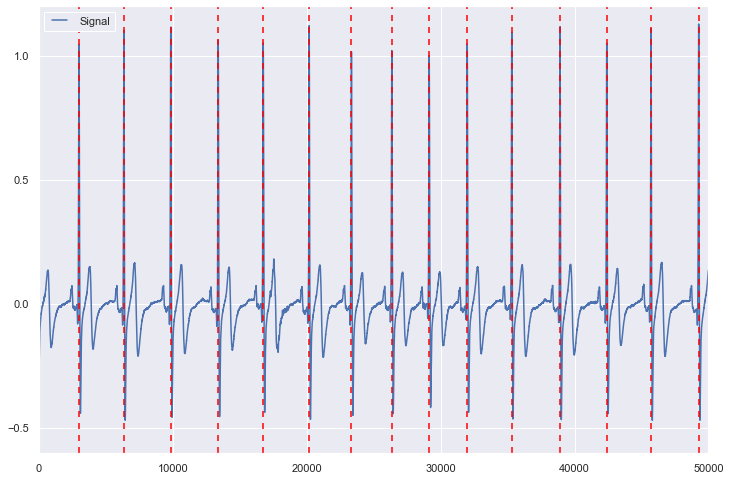

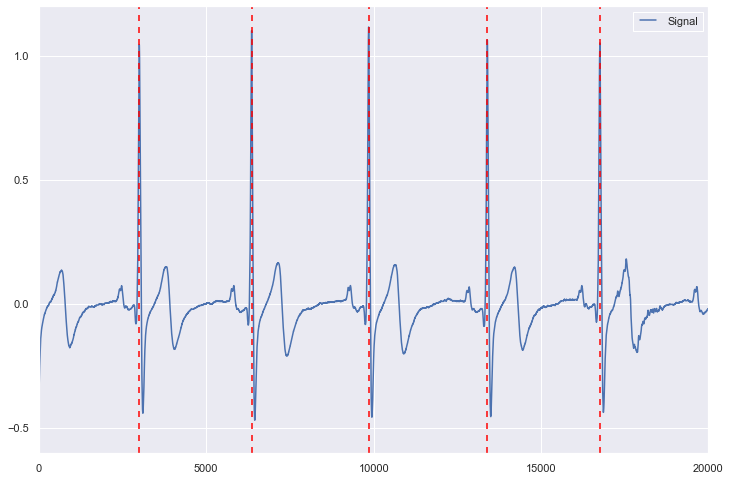

In [159]:
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=3000)
# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)

# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal[:20000])

/Users/nediolus/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



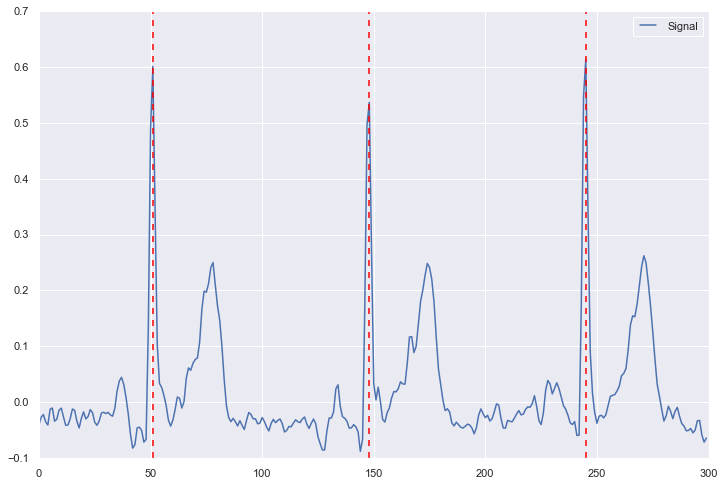

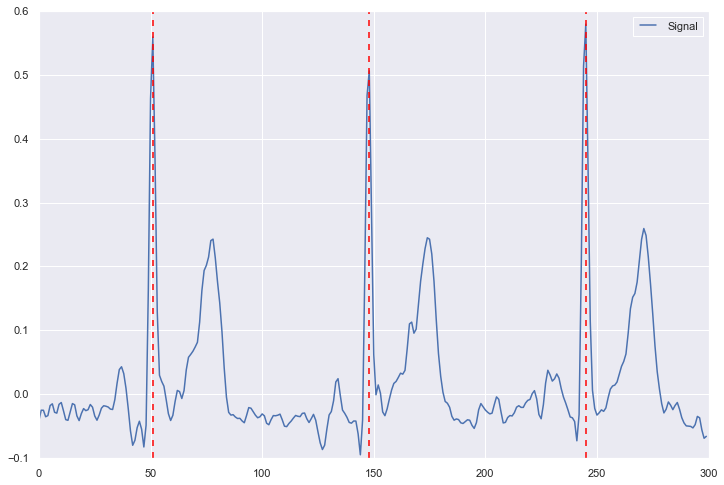

In [204]:
test_ecg = X_test[33][:, 0]
_, rpeaks = nk.ecg_peaks(test_ecg, sampling_rate=100)

# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:3], test_ecg[:300])

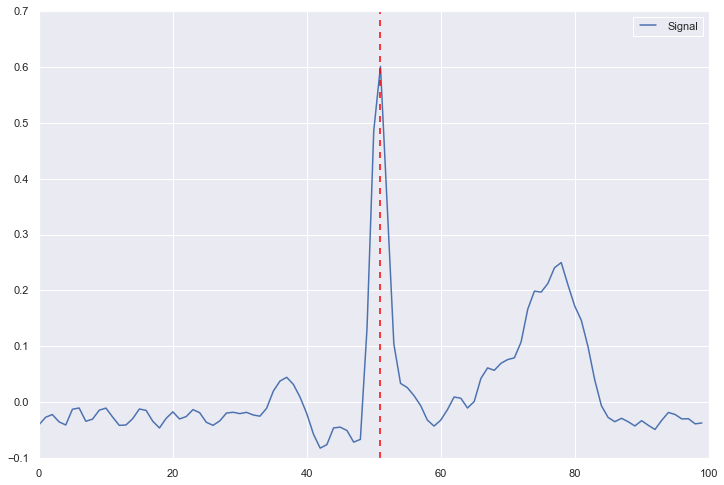

In [228]:
test_ecg = X_test[33][:, 0]
_, rpeaks = nk.ecg_peaks(test_ecg, sampling_rate=100)

# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:1], test_ecg[:100])

In [ ]:
ecg_features = []
nk.ecg_delineation()


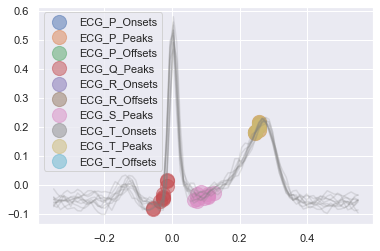

In [44]:

_, rpeaks = nk.ecg_peaks(test_ecg, sampling_rate=100)
all_info = nk.ecg_delineate(test_ecg, rpeaks, sampling_rate=100, method="cwt", show=True, show_type='all')

/Users/nediolus/anaconda3/lib/python3.7/site-packages/neurokit2/events/events_find.py:144: DeprecationWarning:

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/Users/nediolus/anaconda3/lib/python3.7/site-packages/neurokit2/signal/signal_phase.py:82: RuntimeWarning:

invalid value encountered in remainder



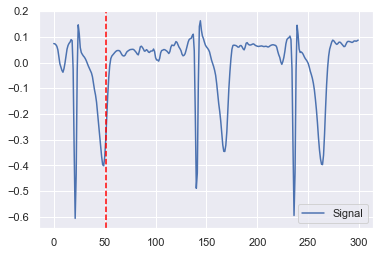

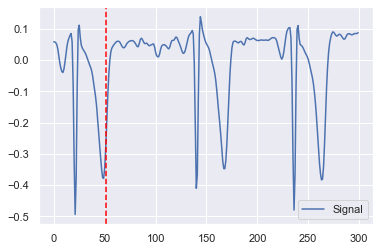

In [184]:
test_ecg = X_test[32][:, 3]
df, info = nk.ecg_process(test_ecg, sampling_rate=100)
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:1], df.ECG_Raw.values[0:300])
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:1], df.ECG_Clean.values[0:300])

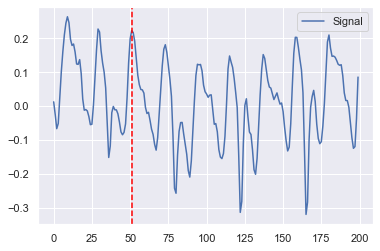

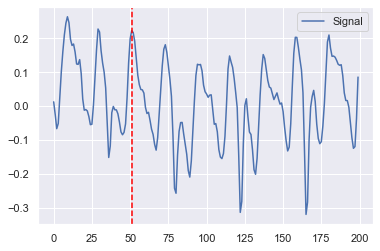

In [89]:
nk.events_plot(rpeaks['ECG_R_Peaks'][:1], values[:200])